🌲 Random Forest R²: 0.1780
📈 Gradient Boosting R²: 0.1128
🧠 Ensemble R²: 0.1620


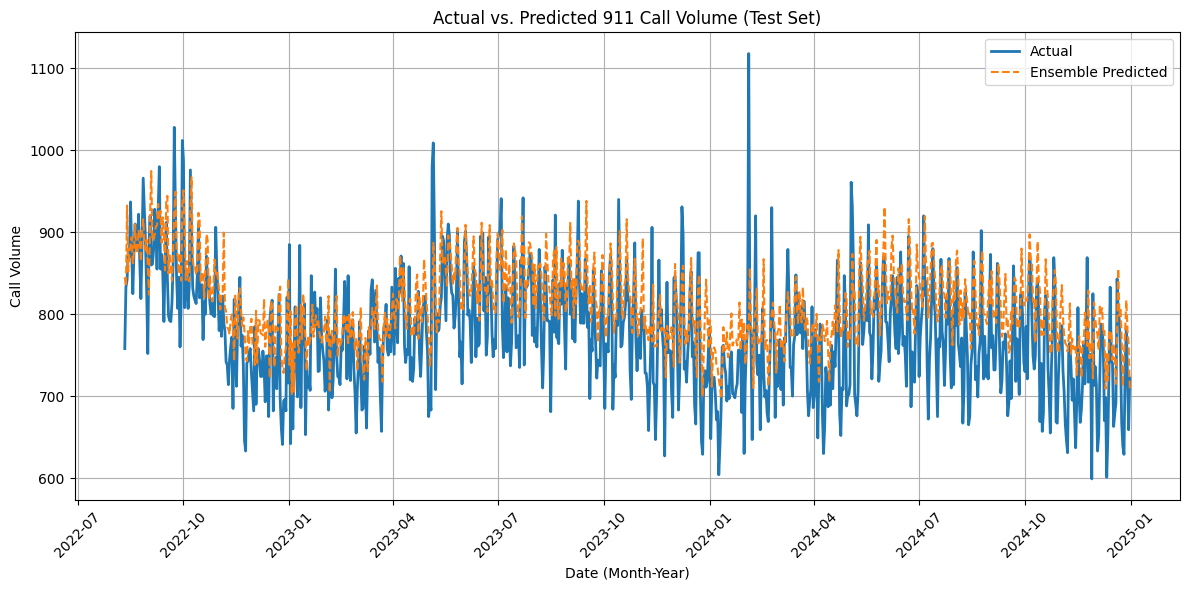

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import holidays

weather_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/weather/weather_clean.csv")
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
calls_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/911_calls_clean.csv")
calls_df['OFFENSE_DATE'] = pd.to_datetime(calls_df['OFFENSE_DATE'])

unemp_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/unemployment_rate/unemployment_rate_clean.csv")
unemp_df.rename(columns={'Month': 'DATE'}, inplace=True)
unemp_df['DATE'] = pd.to_datetime(unemp_df['DATE'])

daily_calls = calls_df.groupby('OFFENSE_DATE').size().reset_index(name='CALL_VOLUME')

weather_features = weather_df[['DATE', 'TAVG', 'RAIN']]
df = pd.merge(daily_calls, weather_features, left_on='OFFENSE_DATE', right_on='DATE', how='left')

df['DAY_OF_WEEK'] = df['OFFENSE_DATE'].dt.dayofweek
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([5, 6]).astype(int)
df['IS_HOLIDAY'] = df['OFFENSE_DATE'].isin(holidays.US()).astype(int)
df['MONTH'] = df['OFFENSE_DATE'].dt.month
df['IS_FIRST_DAY_OF_MONTH'] = (df['OFFENSE_DATE'].dt.day == 1).astype(int)
df['IS_HOT_DAY'] = (df['TAVG'] > 90).astype(int)
df['IS_STORM'] = ((df['RAIN'] == 1) & (df['TAVG'] < 60)).astype(int)
df['RAIN'] = df['RAIN'].fillna(0).astype(int)

df['YEAR_MONTH'] = df['OFFENSE_DATE'].dt.to_period('M')
unemp_df['YEAR_MONTH'] = unemp_df['DATE'].dt.to_period('M')
df = pd.merge(df, unemp_df[['YEAR_MONTH', 'Unemployment']], on='YEAR_MONTH', how='left')

df = df.sort_values('OFFENSE_DATE')
df['CALL_LAG_1'] = df['CALL_VOLUME'].shift(1)
df['CALL_LAG_7'] = df['CALL_VOLUME'].shift(7)
df = df.dropna()

features = [
    'TAVG', 'IS_WEEKEND', 'IS_HOLIDAY', 'RAIN', 'Unemployment',
    'DAY_OF_WEEK', 'MONTH', 'CALL_LAG_1', 'CALL_LAG_7',
    'IS_FIRST_DAY_OF_MONTH', 'IS_HOT_DAY', 'IS_STORM'
]
X = df[features]
y = df['CALL_VOLUME']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42)

rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gbr_pred = gbr.predict(X_test)
ensemble_pred = (rf_pred + gbr_pred) / 2

print(f"🌲 Random Forest R²: {r2_score(y_test, rf_pred):.4f}")
print(f"📈 Gradient Boosting R²: {r2_score(y_test, gbr_pred):.4f}")
print(f"🧠 Ensemble R²: {r2_score(y_test, ensemble_pred):.4f}")

test_dates = df.loc[y_test.index]['OFFENSE_DATE']

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test.values, label="Actual", linewidth=2)
plt.plot(test_dates, ensemble_pred, label="Ensemble Predicted", linestyle='--')
plt.title("Actual vs. Predicted 911 Call Volume (Test Set)")
plt.xlabel("Date (Month-Year)")
plt.ylabel("Call Volume")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()